In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.0 MB/s 
     |████████████████████████████████| 6.6 MB 50.7 MB/s 
     |████████████████████████████████| 120 kB 53.9 MB/s 


In [2]:
import numpy as np
import pandas as pd

import sklearn.model_selection as ms
import sklearn.preprocessing as p

import tensorflow as tf
import transformers as trfs

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [3]:
import tensorflow as tf
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device))

Found GPU at: /device:GPU:0


In [4]:
!nvidia-smi

Wed Sep 21 07:58:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    34W / 250W |    389MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/newdataframe.csv', delimiter=',', encoding= "utf-8")

In [6]:
print(df.head(5))

                                           sentences  label2
0  Neural network translation models, which learn...       1
1  Notably, Devlin et al. (2014) proposed a neura...       1
2  While this model is effective, the computation...       1
3  To solve this problem, Devlin et al. (2014) pr...       1
4  However, they also\nnote that this self-normal...       0


In [10]:
labels = df['label2'].nunique()

In [7]:
# Max length of encoded string(including special tokens such as [CLS] and [SEP]):
MAX_SEQUENCE_LENGTH = 300

# BERT model with lowercase chars only:
PRETRAINED_MODEL_NAME = 'distilbert-base-uncased'

# Batch size for fitting:
BATCH_SIZE = 256

# Number of epochs:
EPOCHS=100

In [11]:
def create_model(max_sequence, model_name, num_labels):

    #This is the input (words from the dataset after encoding):
    input_ids = tf.keras.layers.Input(shape=(max_sequence,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input((max_sequence,), dtype=tf.int32, name='attention_mask')
    token_type_ids = tf.keras.layers.Input((max_sequence,), dtype=tf.int32)
    bert_model = trfs.TFBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, output_hidden_states=False)
    base_output = bert_model.bert([input_ids, attention_mask , token_type_ids])
    #for layer in bert_model.layers:
      #layer.trainable = False
    output = base_output[1]
    outputs = tf.keras.layers.Dense(num_labels, activation='softmax')(output)
    model = tf.keras.models.Model(inputs=[input_ids, attention_mask , token_type_ids], outputs=outputs)
    llist = []
    for k, v in bert_model._get_trainable_state().items():
        llist.append(k)
    print(len(llist))
    layer_list = llist[201:214]
    print(layer_list)
    for k,v in bert_model._get_trainable_state().items():
      if k in layer_list:
        k.trainable = True
      else:
        k.trainable = False
    return model

In [12]:
#Creating the model
model =create_model (MAX_SEQUENCE_LENGTH, PRETRAINED_MODEL_NAME, num_labels=labels)
#Learning rate for the trainable parameters
lr = 2e-5
#Model Optimizer
opt = tf.keras.optimizers.Adam(learning_rate = lr, epsilon=1e-08)
#Compiling the model
model.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'distilbert']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


214
[<keras.layers.core.dense.Dense object at 0x7feac7f3b750>, <keras.layers.normalization.layer_normalization.LayerNormalization object at 0x7feac7f3ba50>, <keras.layers.core.dropout.Dropout object at 0x7feac7fab7d0>, <transformers.models.bert.modeling_tf_bert.TFBertIntermediate object at 0x7feac7f3bfd0>, <keras.layers.core.dense.Dense object at 0x7feac7f433d0>, <transformers.models.bert.modeling_tf_bert.TFBertOutput object at 0x7feac7f436d0>, <keras.layers.core.dense.Dense object at 0x7feac7f43950>, <keras.layers.normalization.layer_normalization.LayerNormalization object at 0x7feac7f43c50>, <keras.layers.core.dropout.Dropout object at 0x7feac7f43d50>, <transformers.models.bert.modeling_tf_bert.TFBertPooler object at 0x7feac7f4b9d0>, <keras.layers.core.dense.Dense object at 0x7feac7f4bc10>, <keras.layers.core.dropout.Dropout object at 0x7feac7f4b990>, <keras.layers.core.dense.Dense object at 0x7feac7ef9410>]


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 300)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 300)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

In [14]:
def batch_encode(X, tokenizer):
    return tokenizer.batch_encode_plus(
    X,
    max_length=MAX_SEQUENCE_LENGTH, # set the length of the sequences
    add_special_tokens=True, # add [CLS] and [SEP] tokens
    return_attention_mask=True,
    return_token_type_ids=True, # not needed for this type of ML task
    pad_to_max_length=True,
    truncation = True, # add 0 pad tokens to the sequences less than max_length
    return_tensors='tf'
)

In [16]:
tokenizer = trfs.DistilBertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
X_total = batch_encode(df["sentences"].values, tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [18]:
X_train, X_val, y_train, y_val = ms.train_test_split(X_total.values(), df["label2"].values, test_size=0.3, random_state=42)

TypeError: ignored

Total: 962015
    Positive: 60882 (6.33% of total)

Weight for class 0: 0.53
Weight for class 1: 7.90
Epoch 1/3
48101/48101 [==============================] - 26070s 542ms/step - loss: 0.5510 - accuracy: 0.8822 - val_loss: 0.5172 - val_accuracy: 0.9363
Epoch 2/3
48101/48101 [==============================] - 26053s 542ms/step - loss: 0.5481 - accuracy: 0.9052 - val_loss: 0.5167 - val_accuracy: 0.9348
Epoch 3/3
48101/48101 [==============================] - 26070s 542ms/step - loss: 0.5460 - accuracy: 0.9160 - val_loss: 0.5042 - val_accuracy: 0.9344


Saved model to disk


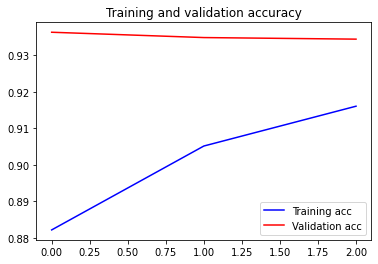

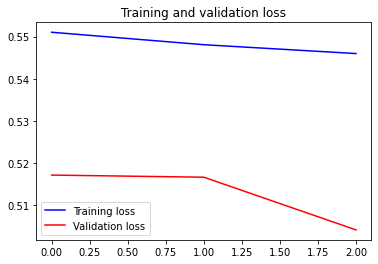

[0.8822198510169983, 0.9051573872566223, 0.9160420894622803]
[0.9362639784812927, 0.9348087310791016, 0.9343773126602173]
[0.5510421395301819, 0.5480852723121643, 0.5459869503974915]
[0.51717209815979, 0.5166683197021484, 0.5041688084602356]


In [35]:
from sklearn.utils import class_weight
neg, pos = np.bincount(df['label2'])
total = neg + pos
print('Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

cls_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

EPOCHS = 3
BATCH_SIZE = 16
NUM_STEPS = len(X_train["input_ids"])/ BATCH_SIZE

# Train the model
history = model.fit(
    x=X_train.values(),
    y=y_train,
    validation_data=(X_val.values(), y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight = {0: 0.53, 1: 5},
)

#tf.saved_model.save(model, "/content/drive/MyDrive/Colab Notebooks/model/sum3/summodel")
model.save("/content/drive/MyDrive/Colab Notebooks/model/sum4/summodel")
print("Saved model to disk")

import matplotlib.pyplot as plt
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,6)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy achieved after every epoch")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss after every epoch")
    plt.legend()
    plt.show()

visualize_results(history)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
print(acc)
print(val_acc)
print(loss)
print(val_loss)

In [15]:
new_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/model/sum4/summodel")

# Check its architecture
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

In [16]:
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/A Binarized Neural Network Joint Model for Machine Translation.csv', delimiter=',', encoding= "utf-8")

In [17]:
X_test = df2["0"].values
X_test = batch_encode(X_test, tokenizer)
logits_score = model.predict(X_test.values())

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [18]:
#model.save('/content/drive/MyDrive/Colab Notebooks/model/sum2/summodel')
#from tensorflow import keras
#new_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/model/sum2/summodel')
logits_score = new_model.predict(X_test.values())
print(new_model)
#from tensorflow import keras
#new_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/model/sum2/summodel')
print(logits_score)
#from scipy.special import softmax
#for logit in logits_score.logits:
  #print(logit)
  #probabilities = softmax(logit, axis=0)
  #print(probabilities)

[[0.6757896  0.3242104 ]
 [0.5363487  0.4636513 ]
 [0.5615463  0.4384537 ]
 [0.60025644 0.39974356]
 [0.5638373  0.43616265]
 [0.51275015 0.48724988]
 [0.63120717 0.36879283]
 [0.5589752  0.44102478]
 [0.5240416  0.4759584 ]
 [0.6627354  0.33726454]
 [0.6514872  0.34851283]
 [0.6497947  0.35020524]
 [0.6291312  0.3708688 ]
 [0.74862    0.25138003]
 [0.7253258  0.2746742 ]
 [0.75227904 0.247721  ]
 [0.7317618  0.2682382 ]
 [0.4500414  0.5499585 ]
 [0.6605949  0.33940506]
 [0.65322906 0.3467709 ]
 [0.6524601  0.34753993]
 [0.64742357 0.35257646]
 [0.6672192  0.33278078]
 [0.7818173  0.2181827 ]
 [0.77533853 0.22466147]
 [0.5809938  0.41900626]
 [0.5269716  0.4730284 ]
 [0.66334176 0.3366582 ]
 [0.4169345  0.5830655 ]
 [0.61037153 0.38962853]
 [0.6627354  0.33726454]
 [0.42371142 0.5762886 ]
 [0.71758884 0.28241113]
 [0.7798854  0.22011456]
 [0.668946   0.33105394]
 [0.6780236  0.3219764 ]
 [0.541271   0.45872906]
 [0.60113585 0.39886418]
 [0.62344426 0.3765557 ]
 [0.6274406  0.3725595 ]


In [43]:
test = df2["0"].values
test2 = batch_encode(test, tokenizer)
score = new_model.predict(test2.values())

row_index=[]
for i in enumerate(score):
  if i[1][1] > 0.5:
    row_index.append(i[0])

for j in enumerate(test):
  #print(j)
  if j[0] in row_index:
    print(j[1])

To estimate these probabilities, the NNJM uses m source context words and n− 1 target history words as input to a neural network and performs estimation of unnormalized probabilities p (ti|C) before normalizing over all words in the target vocabulary V ,
P (ti|C) = p(ti|C)Z(C) Z (C) = ∑ ti′∈V p (ti′|C) (2)
where C stands for source and target context words as in Equation 1.

In this paper, we propose a new framework of the binarized NNJM (BNNJM), which is similar to the NNJM but learns not to predict the next word given the context, but solves a binary classification problem by adding a variable v ∈ {0, 1} that stands for whether the current target word ti is correctly/wrongly produced in terms of source context words sai+(m−1)/2ai−(m−1)/2 and target history words ti−1i−n+1 ,
P ( v|sai+(m−1)/2ai−(m−1)/2, t i−1 i−n+1, ti ) .

Thus, the hidden layers can be used to learn the difference between correct target words and noise in the BNNJM, while in the NNJM the hidden layers just contain i